# Explaining Tree Construction

In [62]:
from __future__ import annotations
import numpy as np
import itertools
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd
from scipy.optimize import linprog
from typing import Dict, List, Optional, Tuple, Iterable
from scipy.optimize import linprog
import sys
import os
import matplotlib.pyplot as plt
import time

sys.path.append('../')

## The Region

In [63]:
# Region class as dataclass
from intvalpy import lineqs
class Region:
    def __init__(self, activation=None, input_dim=None):
        # Region attributes
        self.qlw = activation # Activation pattern
        self.qlw_tilde = None # Active bits in activation pattern (indices)
        self.bounded = None
        
        # Inequalities and projections
        
        
        if input_dim is not None:
            self.Alw = np.eye(input_dim) # Slope projection matrix
            self.clw = np.zeros((input_dim, 1)) # Intercept projection matrix
            
            
            # Generate hypercube inequalities
            # Each dimension has 2 constraints (upper and lower bound)
            # D will have 2n rows and n columns
            self.Dlw  = np.zeros((2 * input_dim, input_dim))
            # g will be a vector of all 1s since |x_i| <= 1
            self.glw  = np.ones((2 * input_dim, 1))
            
            for i in range(input_dim):
                # Constraint for x_i <= 1
                self.Dlw[2 * i, i] = 1
                # Constraint for -x_i <= 1 (which is x_i >= -1)
                self.Dlw[2 * i + 1, i] = -1
                
            # self.Dlw_active = self.Dlw # Active slopes
            # self.glw_active = self.glw # Active intercepts
        else:
            self.Alw = None # Slope projection matrix
            self.clw = None # Intercept projection matrix
            
            self.Dlw = None # Slopes of inequalities
            self.glw = None # Intercept of inequalities 
            
        self.Dlw_active = None # Active slopes
        self.glw_active = None # Active intercepts
        
        # Tree attributes
        self.parent = None # Parent Region object
        self.children = [] # List of children (Region objects)
        
        # Utility attributed
        self.layer_number = 0 # Layer to which this region belongs
        self.region_index = 0 # Index to identify regions #TODO necessary?

        # Estimation attributes
        self.volume_estimate = None
        self.vertices = None
        self.sample_points = {}
        
    def add_child(self, child):
        child.parent = self
        self.children.append(child)
        
    def is_leaf(self):
        return len(self.children) == 0
    
    def is_root(self):
        return self.parent is None
    
    def get_children(self):
        return self.children
    
    def get_depth(self):
        depth = 0
        node = self
        while node.parent is not None:
            node = node.parent
            depth += 1
        assert depth == self.layer_number, "Depth and layer number are not equal"
        return depth
    
    def get_ancestors(self):
        ancestors = []
        node = self
        
        while node.parent is not None:
            ancestors.append(node.parent)
            node = node.parent
        
        return ancestors[::-1]
    
    def get_path_inequalities(self):
        D_list = []
        g_list = []
        node = self
        
        while node.parent is not None:
            D_list.append(node.Dlw_active)
            g_list.append(node.glw_active)
            node = node.parent
        
        D_path = np.vstack(D_list[::-1])
        g_path = np.vstack(g_list[::-1])
        
        return D_path, g_path
    
    
    def __str__(self):
        returnstring = f"\n--------------\nRegion info:\n--------------\nLayer: {self.layer_number}\nIndex: {self.region_index}\nLocal activation: {self.qlw}\nInput dim: {self.Alw.shape[1] if self.Alw is not None else 'N/A'}\nChildren: {len(self.children)}"
        if self.is_root():
            returnstring += "\nThis is the root region."
        elif self.is_leaf():
            returnstring += "\nThis is a leaf region."
            returnstring += f"\nAncestors: {len(self.get_ancestors())}"
        return returnstring  

## The Tree

In [ ]:
class Tree:
    def __init__(self, state_dict):
        # Find the hyperplanes from the state dict
        self.hp = self._find_hyperplanes(state_dict)
        self.input_dim = self.hp[0].shape[1] - 1  # Assuming all hyperplanes have the same input dimension
        self.L = len(self.hp)  # Number of layers
        
        # Initialize the root region
        self.root = Region(input_dim = self.input_dim)

    # ----------------------------------------------------------------------
    # External methods
    # ----------------------------------------------------------------------

    # Tree construction
    def construct_tree(self, verbose=False):
        current_layer_nodes = [self.root]
        for l in range(self.L):
            next_layer_nodes = []
            for node in tqdm(current_layer_nodes, desc=f"Processing layer {l+1}", leave=False) if verbose else current_layer_nodes:
                # 1. Find subregions for the current node
                
                #TODO Check if parallelizable
                self._find_subregions(node, self.hp, verbose=False)
                
                # 2. Add children to next layer nodes
                next_layer_nodes.extend(node.get_children())
                
            current_layer_nodes = next_layer_nodes
            # Optional: Break if there are no more children to process
            if not current_layer_nodes:
                break




    # ----------------------------------------------------------------------
    # Get-methods
    # ----------------------------------------------------------------------

    def get_regions_at_layer(self, layer: int):
        regions = []
        queue = [self.root]
        
        while queue:
            current_region = queue.pop(0)
            
            if current_region.layer_number == layer:
                regions.append(current_region)
            elif current_region.layer_number < layer:
                queue.extend(current_region.get_children())
        return regions



    # ----------------------------------------------------------------------
    # Internal methods
    # ----------------------------------------------------------------------
    
    # Hyperplane extraction from state_dict
    def _find_hyperplanes(self, state_dict):
        weights = []
        biases = []
        hyperplanes = [] 
        for key, val in state_dict.items():
            if "weight" in key:
                weights.append(val)
            elif "bias" in key:
                biases.append(val)
        for W, b in zip(weights, biases):
            hyperplanes.append(np.hstack((W, b.reshape(-1,1))))
        return hyperplanes
    
    def _find_subregions(self, parent, hyperplanes, verbose=False):
        # Find point
        x = self._get_interior_point_adaptive(parent, verbose=verbose).reshape(-1,1)
        
        # Global contraints
        D_global = parent.Dlw_active
        g_global = parent.glw_active
        # Weight and biases of parent layer +1
        layer = parent.layer_number + 1
        Wl, bl = self._get_weights_and_biases_from_hyperplanes(hyperplanes, layer=layer)
        
        # Find activation of point
        q0 = self._find_activation_pattern(x, Wl, bl, parent.Alw, parent.clw)
        
        # 1. Initialize
        traversed = {}
        actives = {} # Dictionary with indices of active neurons for each activation
        queue = [self._to_tuple(q0)]
        # traversed[to_tuple(q0)] = True
        # 2. Process until no new states are found
        region_idx = 0
        while queue:
            current_key = queue.pop(0)  # Get the next state to process
            current_q = np.array(current_key) 
            
            # Calculate relevant quantities
            # Slw = get_sign_matrix(current_q)
            
            # Get sign vector
            slw = -2 * current_q +1
            # Get sign matrix
            Slw = np.diag(slw.ravel())
            
            # Find local inequalities
            local_hyperplane_slopes = Wl @ parent.Alw
            local_hyperplane_intercepts = Wl @ parent.clw + bl
            Dlw = Slw @ local_hyperplane_slopes
            glw = - Slw @ local_hyperplane_intercepts
            
            
            # Find active indices
            if layer == 1:
                local_active_indices, is_bounded = self._find_active_bits(Dlw, glw) 
            else:
                local_active_indices, is_bounded = self._find_active_bits(Dlw, glw, D_global, g_global) 
            actives[current_key] = local_active_indices
            
            # Initialize new region
            new_region = Region(current_q)
            new_region.q_tilde = local_active_indices
            new_region.bounded = is_bounded
            new_region.Dlw = Dlw
            new_region.glw = glw
            new_region.Dlw_active = Dlw[list(local_active_indices),:]
            new_region.glw_active = glw[list(local_active_indices)]
            # new_region.find_active_inequalities()
            
            # Compute projections for that region
            Qlw = np.diag(current_q.ravel())
            new_region.Alw = Qlw @ local_hyperplane_slopes
            new_region.clw = Qlw @ local_hyperplane_intercepts
            
            # Place region in region tree
            new_region.layer_number = layer
            new_region.region_index = region_idx
            region_idx += 1
            parent.add_child(new_region)
            
            traversed[current_key] = True
            
            for active_idx in local_active_indices:
                # Generate neighbor
                q_new = current_q.copy()
                q_new[active_idx] ^= 1
                new_key = self._to_tuple(q_new)
                
                # 3. Only add if we haven't seen it before
                if new_key not in traversed:
                    traversed[new_key] = False
                    queue.append(new_key)  # Add to queue to be processed in a future loop
                    
            # Mark the current one as fully processed
            traversed[current_key] = True
            
    
    def _solve_single_lp(self, args):
        """
        Tests if a SPECIFIC local constraint i is active GIVEN the global domain.
        """
        target_idx, D_all, g_all, tol, bounds = args
        
        # The direction we want to push to see if we can "cross" this boundary
        d_i = D_all[target_idx]
        
        # We must satisfy ALL constraints EXCEPT the one we are testing
        D_tilde = np.delete(D_all, target_idx, axis=0)
        g_tilde = np.delete(g_all, target_idx, axis=0)

        try:
            res = linprog(
                c=-d_i, # Maximize distance past the boundary
                A_ub=D_tilde,
                b_ub=g_tilde,
                bounds=bounds,
                method="highs",
            )
        except ValueError as e:
            if "HiGHS Status 15" in str(e):
                return target_idx, False 
            raise e

        if res.x is not None:
            val = -res.fun if res.fun is not None else np.dot(d_i, res.x)
            # If we can cross the boundary (val > g[i]), the neighbor is reachable
            if val > g_all[target_idx] + tol:
                return target_idx, True
            return -1, True
        
        elif res.status == 3: # Unbounded past the boundary
            return target_idx, False
        
        return -1, True

    def _find_active_bits(self, D_local, g_local, D_global=None, g_global=None, tol=1e-7):
        """
        Only solves LPs for local constraints, but uses global constraints as bounds.
        """
        D_local = np.asarray(D_local)
        g_local = np.asarray(g_local).flatten()
        
        n_local = D_local.shape[0]
        dim = D_local.shape[1]
        
        # Combine everything for the background constraints if there are any
        if D_global is not None and g_global is not None:
            D_global = np.asarray(D_global)
            g_global = np.asarray(g_global).flatten()
            D_all = np.vstack([D_local, D_global])
            g_all = np.concatenate([g_local, g_global])
        else: # If no global constraints, just use local
            D_all = D_local
            g_all = g_local
        
        bounds = [(None, None)] * dim
        active_local_bits = []
        is_bounded = True
        
        # Only create tasks for the LOCAL indices (0 to n_local - 1)
        tasks = [(i, D_all, g_all, tol, bounds) for i in range(n_local)]
        
 
        for task in tasks:
            idx, bounded = self._solve_single_lp(task)
            if idx != -1:
                active_local_bits.append(idx)
            if not bounded:
                is_bounded = False
                    
        return np.array(sorted(active_local_bits)), is_bounded
          
    def _get_interior_point_adaptive(self, region, initial_slack=0.1, min_threshold=1e-10, verbose=False):
        """
        Finds a point inside Ax <= b. If min_slack is too large, 
        it recursively tries with smaller slack.
        """
        A = region.Dlw_active
        b = region.glw_active
        if A is None or b is None:
            A = region.Dlw
            b = region.glw
        
        m, n = A.shape
        
        # Ensure inputs are flat 1D arrays to avoid the Dimension/Shape ValueError
        b = np.asarray(b).flatten()
        norms = np.linalg.norm(A, axis=1).flatten()
        c = np.zeros(n)
        
        current_slack = initial_slack
        print(f"Searching for point...") if verbose else None
        while current_slack >= min_threshold:
            # Apply the shrinking logic
            b_shrunk = b - (current_slack * norms)
            
            # Try to solve the LP
            res = linprog(c, A_ub=A, b_ub=b_shrunk, 
                        bounds=[(None, None)] * n, 
                        method='highs')
            
            if res.success:
                print(f"Success found with slack: {current_slack}") if verbose else None
                return res.x
            
            # If infeasible, reduce slack and try again
            print(f"Slack {current_slack} too large, trying {current_slack/10}...") if verbose else None
            current_slack /= 10
            
        # Final attempt: try with zero slack (finds any point on/in the boundary)
        res_final = linprog(c, A_ub=A, b_ub=b, bounds=[(None, None)] * n, method='highs')
        if res_final.success:
            return res_final.x
            
        raise ValueError("Polytope is empty or infeasible even with zero slack.")

    def _get_weights_and_biases_from_hyperplanes(self, hyperplanes, layer=1):
        weights = hyperplanes[layer-1][:,:-1] # Shape (hl, hl-1)
        biases = hyperplanes[layer-1][:,-1].reshape(-1,1) # shape (hl, 1)
        return weights, biases

    def _find_activation_pattern(self, x, Wl, bl, Alw_prev, clw_prev):
        z = Wl @ Alw_prev @ x + Wl @ clw_prev + bl
        return (z>0).astype(int)

    def _to_tuple(self, array):
        return tuple(array.ravel())
    
    def some():
        pass

## Is it working?

### Data

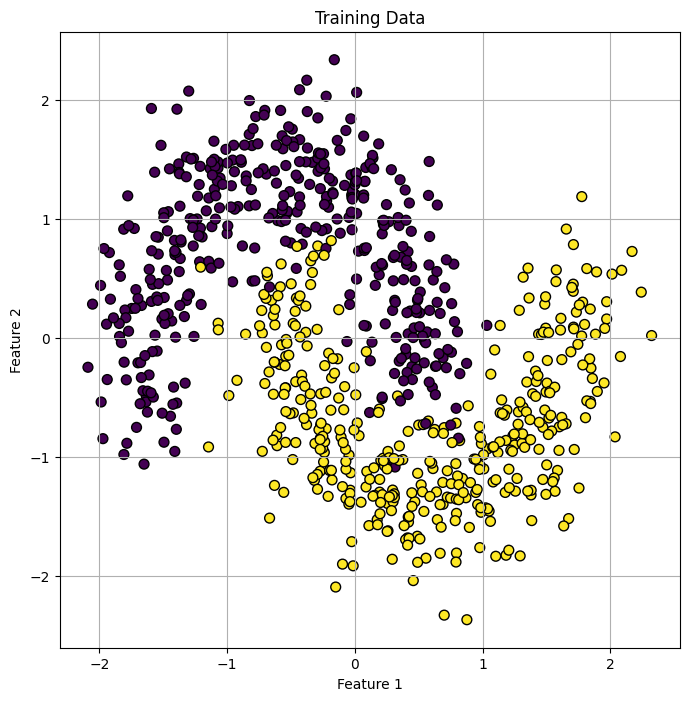

In [65]:
from src_experiment import get_moons_data, train_model, NeuralNet
train, test = get_moons_data(feature_noise=0.2)
all_features = []
all_labels = []

for features, labels in train:
    all_features.append(features.detach().cpu())
    all_labels.append(labels.detach().cpu())

# Combine batches into one large array
import torch
X = torch.cat(all_features, dim=0).numpy()
y = torch.cat(all_labels, dim=0).numpy()

plt.figure(figsize=(8,8))

# 3. Plot using the first two columns (dimensions) of the features
# X[:, 0] is Feature 1, X[:, 1] is Feature 2
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)

plt.title("Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

### Model

Training not saved.


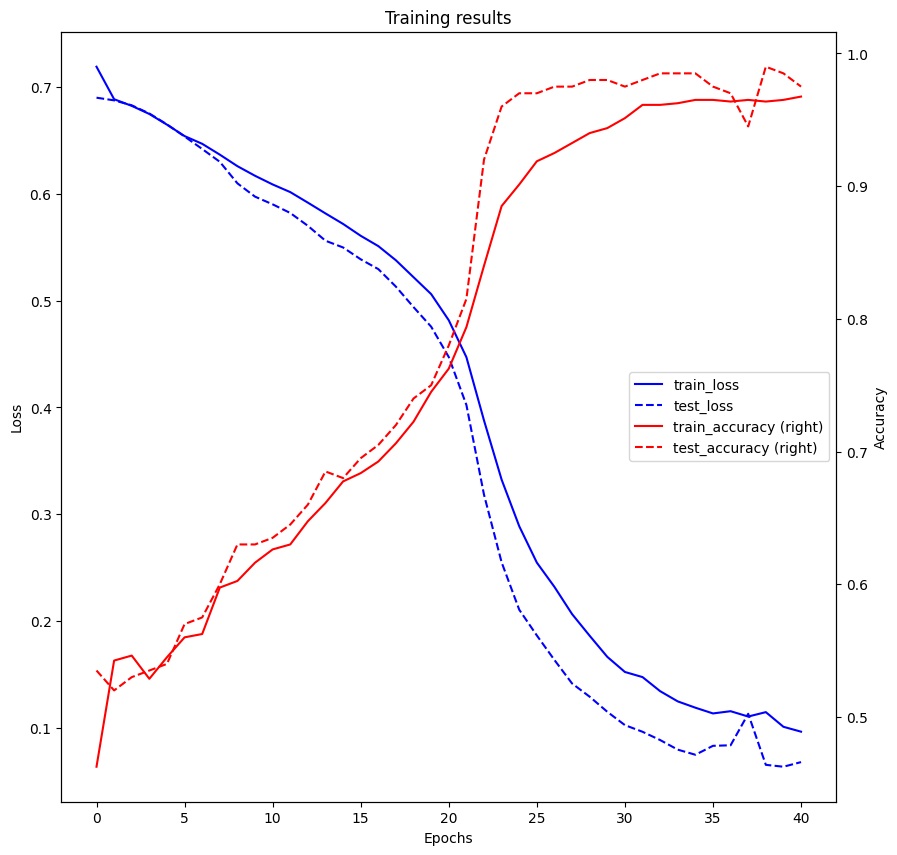

In [66]:
from visualization import plot_training
hidden_sizes = [0,5,5,5,5]

ActNet = NeuralNet(
    input_size = 2,
    hidden_sizes = hidden_sizes[1:],
    num_classes=1,
    seed=3,
)

res, states = train_model(ActNet, train, test, epochs=41, save_everyth_epoch=10, RETURN_STATES=True)
plot_training(res)

### Build tree

In [67]:
trees = {}
for epoch, state in states.items():
    print(f"\n--- Epoch {epoch} ---")
    tree = Tree(state)
    tree.construct_tree(verbose=True)
    trees[epoch] = tree


--- Epoch 0 ---



--- Epoch 10 ---



--- Epoch 20 ---



--- Epoch 30 ---



--- Epoch 40 ---


### Visualize the tree

In [70]:
def find_vertices_from_regions(regions, bound=10):
    vertices_list = []
    for region in regions:
        # if region.layer_number == 1:
        #     D = region.Dlw_active
        #     g = region.glw_active
        # else:
        #     D = np.vstack([region.Dlw_active, region.parent.Dlw_active])
        #     g = np.vstack([region.glw_active, region.parent.glw_active])
        D, g = region.get_path_inequalities()
        
        try:
            # Use a small tolerance or check feasibility first
            verts = lineqs(-D, -g, bounds=[[-bound,-bound], [bound,bound]], show=False, size=(5,5))
            vertices_list.append(verts)
        except (IndexError, ValueError) as e:
            # print(D, g)
            print("Warning: Polytope has no vertices or is empty. Skipping visualization.")
            continue
    return vertices_list

In [73]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

def plot_epoch_layer_grid(trees, num_layers=4, bound=50):
    epochs = sorted(trees.keys())
    num_epochs = len(epochs)
    
    # 1. Setup the figure: Rows = Layers, Cols = Epochs
    fig, axes = plt.subplots(num_layers, num_epochs, 
                             figsize=(num_epochs * 3, num_layers * 3), 
                             constrained_layout=True)
    
    # Standardize axes to a 2D array for consistent indexing [row, col]
    if num_layers == 1 and num_epochs == 1:
        axes = np.array([[axes]])
    elif num_layers == 1:
        axes = axes[np.newaxis, :]
    elif num_epochs == 1:
        axes = axes[:, np.newaxis]

    # 2. Iterate through Epochs (Columns)
    for col, epoch in enumerate(epochs):
        tree = trees[epoch]
        
        # 3. Iterate through Layers (Rows)
        for row in range(num_layers):
            layer_idx = row + 1
            ax = axes[row, col]
            
            # Access existing regions at this specific layer for this specific root
            regions = tree.get_regions_at_layer(layer=layer_idx)
            
            vertices_list = find_vertices_from_regions(regions, bound=5000)
            
            # 4. Draw Polygons
            for vert in vertices_list:
                # Basic boundary check for the 2D slice
                within_boundaries = any(-bound <= coord[0] <= bound and 
                                        -bound <= coord[1] <= bound for coord in vert)
                
                if within_boundaries:
                    # Plot the polygon
                    poly = Polygon(xy=vert, 
                                   facecolor=np.random.rand(3,), 
                                   edgecolor="black", 
                                   alpha=0.6, 
                                   linewidth=0.5)
                    ax.add_patch(poly)

            # Formatting each subplot
            ax.set_xlim([-bound, bound])
            ax.set_ylim([-bound, bound])
            ax.set_aspect('equal')
            
            # Labels: Epochs on top, Layers on the left
            if row == 0:
                ax.set_title(f"Epoch {epoch}", fontsize=14, fontweight='bold')
            if col == 0:
                ax.set_ylabel(f"Layer {layer_idx}", fontsize=14, fontweight='bold')
            
            # Remove tick clutter for inner plots
            if row < num_layers - 1:
                ax.set_xticks([])
            if col > 0:
                ax.set_yticks([])

    return fig, axes


(<Figure size 1500x1200 with 20 Axes>,
 array([[<Axes: title={'center': 'Epoch 0'}, ylabel='Layer 1'>,
         <Axes: title={'center': 'Epoch 10'}>,
         <Axes: title={'center': 'Epoch 20'}>,
         <Axes: title={'center': 'Epoch 30'}>,
         <Axes: title={'center': 'Epoch 40'}>],
        [<Axes: ylabel='Layer 2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Layer 3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Layer 4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
       dtype=object))

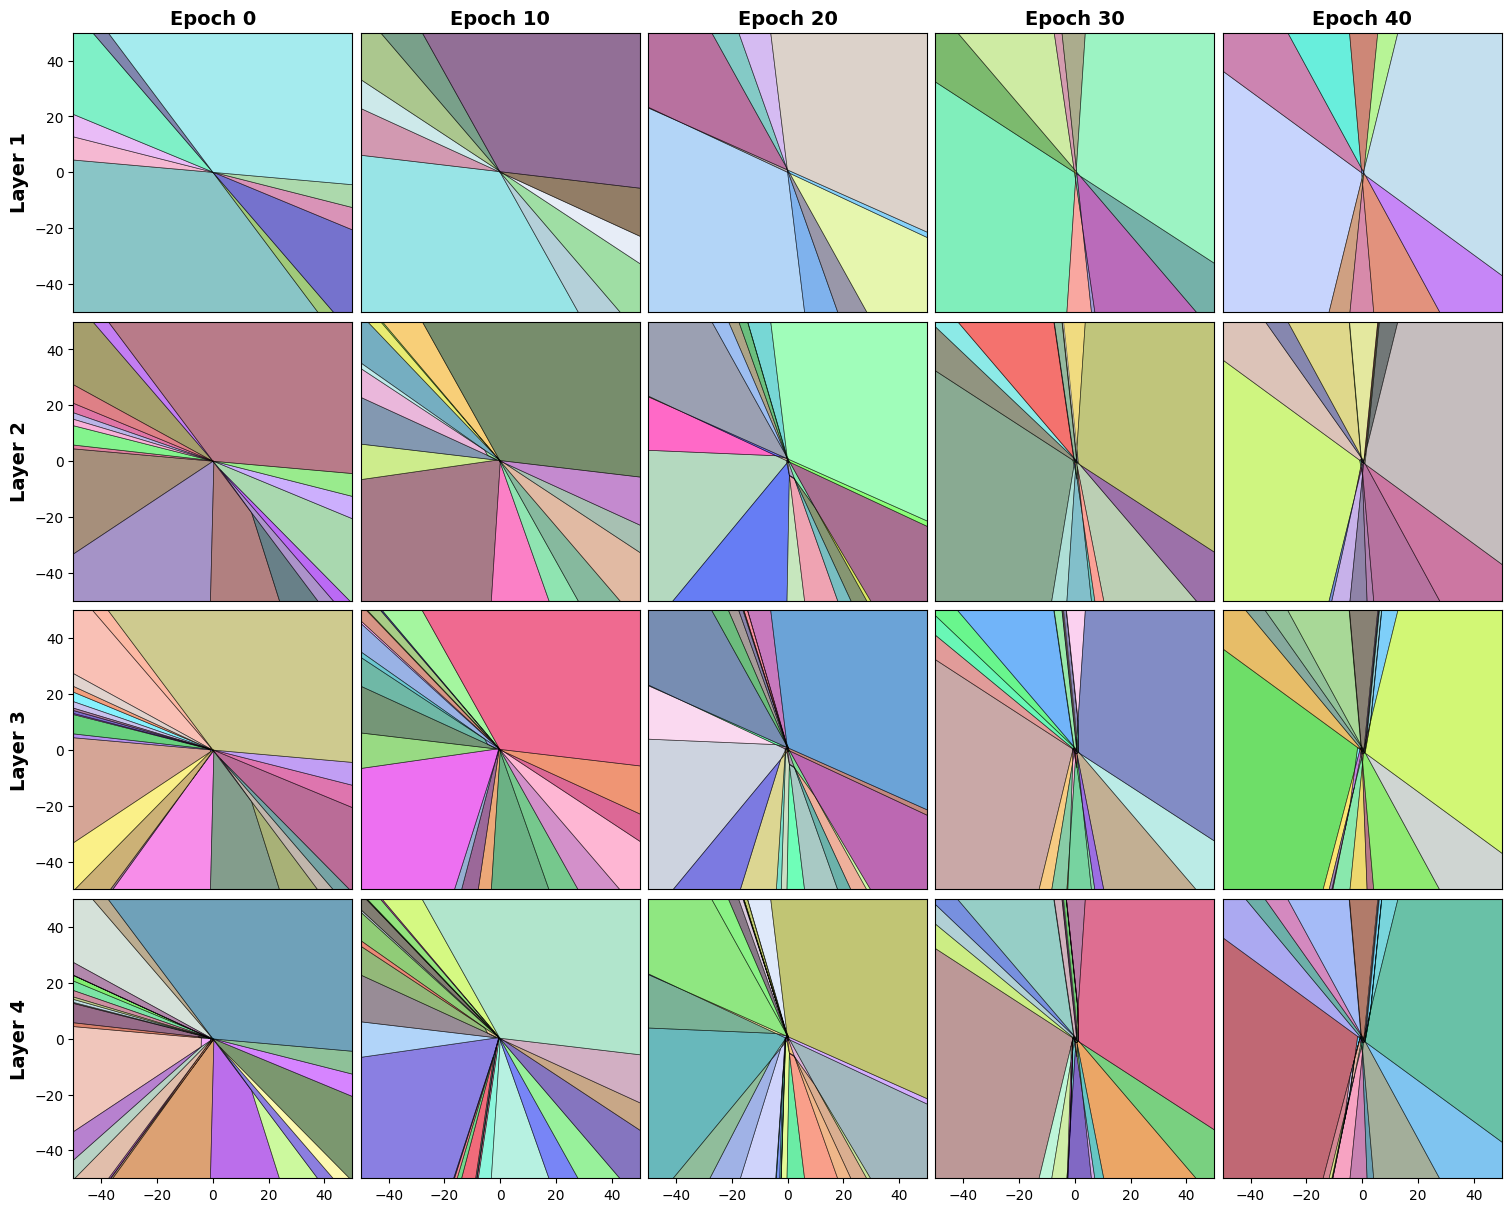

In [74]:
plot_epoch_layer_grid(trees)